## GeneChip® Mouse Exon 1.0 ST Array (Mouse Transcriptome Assay 1.0)
>With approximately four probes per exon and roughly 40 probes per gene, the GeneChip® Mouse Exon 1.0 ST Array enables two complementary levels of analysis—gene expression and alternative splicing.
Multiple probes per exon enable "exon-level" analysis and allow you to distinguish between different isoforms of a gene. This exon-level analysis on a whole-genome scale opens the door to detecting specific alterations in exon usage that may play a central role in disease mechanism and etiology.
The second level is "gene-level" expression analysis, in which multiple probes on different exons are summarized into an expression value of all transcripts from the same gene.
Exon arrays provide the most comprehensive coverage of the genome, including empirically supported and predicted transcribed sequences, enabling the discovery of previously unidentified novel events.

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install()
install.packages("devtools")
library(devtools)
install_github("r-lib/remotes")
library(remotes)
# install_github("b-klaus/maEndToEnd")

Bioconductor version 3.9 (BiocManager 1.30.4), R 3.6.1 (2019-07-05)



The downloaded binary packages are in
	/var/folders/hd/_qjx3t756vvb02_wx55jwqc40000gn/T//RtmpPOqC0E/downloaded_packages


Loading required package: usethis
Skipping install of 'remotes' from a github remote, the SHA1 (3e042a2c) has not changed since last install.
  Use `force = TRUE` to force installation

Attaching package: ‘remotes’

The following objects are masked from ‘package:devtools’:

    dev_package_deps, install_bioc, install_bitbucket, install_cran,
    install_deps, install_dev, install_git, install_github,
    install_gitlab, install_local, install_svn, install_url,
    install_version, update_packages

The following object is masked from ‘package:usethis’:

    git_credentials



In [2]:
library(pd.mta.1.0)
library(mta10probeset.db)
library(oligo)
library(limma)
library(dplyr)
library(ggplot2)
install.packages("plotly")
library(plotly)
library(geneplotter)
library(RColorBrewer)
library(pheatmap)
install.packages("Rtsne")
library(Rtsne)
install_github("wjawaid/enrichR")
library(enrichR)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome


The downloaded binary packages are in
	/var/folders/hd/_qjx3t756vvb02_wx55jwqc40000gn/T//RtmpPOqC0E/downloaded_packages


Loading required package: lattice
Loading required package: annotate
Loading required package: XML
Skipping install of 'enrichR' from a github remote, the SHA1 (019a2f73) has not changed since last install.
  Use `force = TRUE` to force installation
Welcome to enrichR
Checking connection ... Connection is Live!
Loading required package: RSQLite
Loading required package: DBI


In [3]:
setwd("~/Work/19 10-Sep Dirk Homann/Microarray HL project/CEL files")

In [4]:
cel_files<-list.celfiles()

In [5]:
cel_files

[1] "DH5881-CLMD_Mo-8.1.CEL" "DH5881-CLMD_Mo-8.2.CEL" "DH5881-CLMD_Mo-8.3.CEL"
[4] "DH5881-CLMD_Mo-8.4.CEL" "DH5881-CLMD_Mo-8.5.CEL" "DH5881-CLMD_Mo-8.6.CEL"
[7] "DH5881-CLMD_Mo-8.7.CEL" "DH5881-CLMD_Mo-8.8.CEL"

Read manaully created description file

In [6]:
SDRF <- read.delim("DH5881.sdrf.txt")

In [7]:
rownames(SDRF) <- SDRF$Array.Data.File

In [8]:
SDRF <- AnnotatedDataFrame(SDRF)

In [9]:
SDRF$Array.Data.File

[1] DH5881-CLMD_Mo-8.1.CEL DH5881-CLMD_Mo-8.2.CEL DH5881-CLMD_Mo-8.3.CEL
[4] DH5881-CLMD_Mo-8.4.CEL DH5881-CLMD_Mo-8.5.CEL DH5881-CLMD_Mo-8.6.CEL
[7] DH5881-CLMD_Mo-8.7.CEL DH5881-CLMD_Mo-8.8.CEL
8 Levels: DH5881-CLMD_Mo-8.1.CEL ... DH5881-CLMD_Mo-8.8.CEL

In [10]:
raw_data <- oligo::read.celfiles(filenames = file.path(".", SDRF$Array.Data.File), verbose = FALSE, phenoData = SDRF)

Reading in : ./DH5881-CLMD_Mo-8.1.CEL
Reading in : ./DH5881-CLMD_Mo-8.2.CEL
Reading in : ./DH5881-CLMD_Mo-8.3.CEL
Reading in : ./DH5881-CLMD_Mo-8.4.CEL
Reading in : ./DH5881-CLMD_Mo-8.5.CEL
Reading in : ./DH5881-CLMD_Mo-8.6.CEL
Reading in : ./DH5881-CLMD_Mo-8.7.CEL
Reading in : ./DH5881-CLMD_Mo-8.8.CEL


Warning message in oligo::read.celfiles(filenames = file.path(".", SDRF$Array.Data.File), :
“'channel' automatically added to varMetadata in phenoData.”

In [11]:
head(Biobase::pData(raw_data))

,Source.Name,Individual,Organism,Phenotype,Array.Data.File,X
,<fct>,<dbl>,<fct>,<fct>,<fct>,<lgl>
DH5881-CLMD_Mo-8.1.CEL,C1 RNA d8,8.1,Mus musculus,control,DH5881-CLMD_Mo-8.1.CEL,NA
DH5881-CLMD_Mo-8.2.CEL,C2 RNA d8,8.2,Mus musculus,control,DH5881-CLMD_Mo-8.2.CEL,NA
DH5881-CLMD_Mo-8.3.CEL,C3 RNA d8,8.3,Mus musculus,control,DH5881-CLMD_Mo-8.3.CEL,NA
DH5881-CLMD_Mo-8.4.CEL,C4 RNA d8,8.4,Mus musculus,control,DH5881-CLMD_Mo-8.4.CEL,NA
DH5881-CLMD_Mo-8.5.CEL,HL1 RNA d8,8.5,Mus musculus,helpless,DH5881-CLMD_Mo-8.5.CEL,NA
DH5881-CLMD_Mo-8.6.CEL,HL2 RNA d8,8.6,Mus musculus,helpless,DH5881-CLMD_Mo-8.6.CEL,NA


Following protocol from https://bioconductor.org/packages/devel/workflows/vignettes/maEndToEnd/inst/doc/MA-Workflow.html#14_a_pathway_enrichment_analysis_using_reactome

In [12]:
Biobase::exprs(raw_data)[1:5, 1:5]

DH5881-CLMD_Mo-8.1.CEL,DH5881-CLMD_Mo-8.2.CEL,DH5881-CLMD_Mo-8.3.CEL,DH5881-CLMD_Mo-8.4.CEL,DH5881-CLMD_Mo-8.5.CEL
4115,5152,5532,3941,5077
188,227,192,155,250
4505,5422,5370,4304,5010
164,149,145,130,183
178,158,145,148,165


In [13]:
exp_raw <- log2(Biobase::exprs(raw_data))

In [14]:
PCA_raw <- prcomp(t(exp_raw), scale. = FALSE)

In [15]:
percentVar <- round(100*PCA_raw$sdev^2/sum(PCA_raw$sdev^2),1)

In [16]:
sd_ratio <- sqrt(percentVar[2] / percentVar[1])

In [17]:
dataGG <- data.frame(PC1 = PCA_raw$x[,1], PC2 = PCA_raw$x[,2],
                    Phenotype = pData(raw_data)$Phenotype,
                    Individual = pData(raw_data)$Individual)

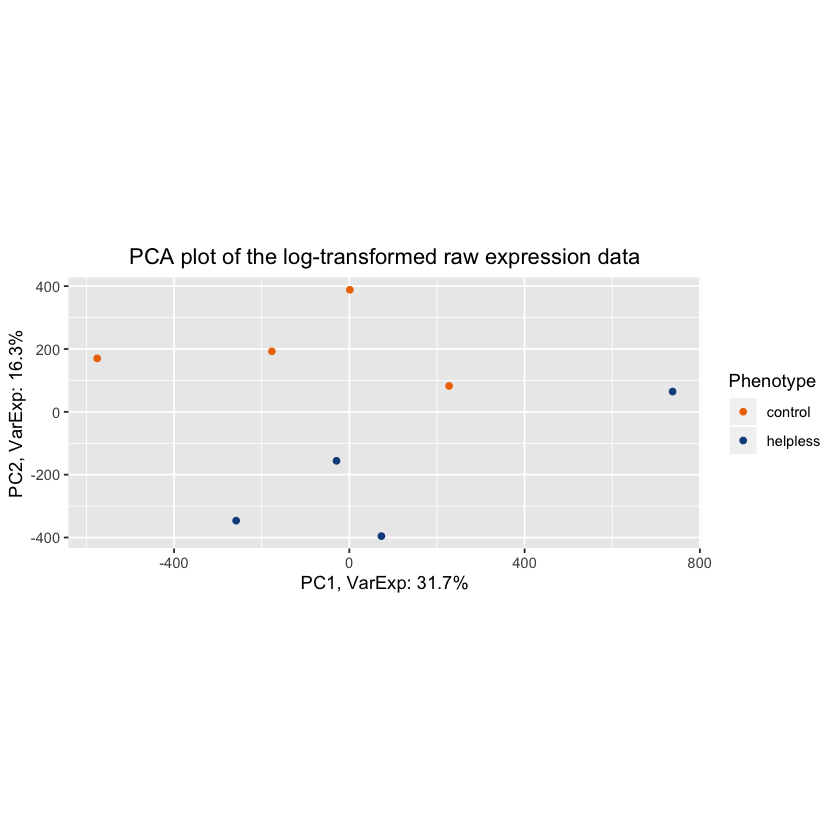

In [18]:
ggplot(dataGG, aes(PC1, PC2)) +
      geom_point(aes(colour = Phenotype)) +
  ggtitle("PCA plot of the log-transformed raw expression data") +
  xlab(paste0("PC1, VarExp: ", percentVar[1], "%")) +
  ylab(paste0("PC2, VarExp: ", percentVar[2], "%")) +
  theme(plot.title = element_text(hjust = 0.5))+
  coord_fixed(ratio = sd_ratio) +
  scale_shape_manual(values = c(4,15)) + 
  scale_color_manual(values = c("darkorange2", "dodgerblue4"))

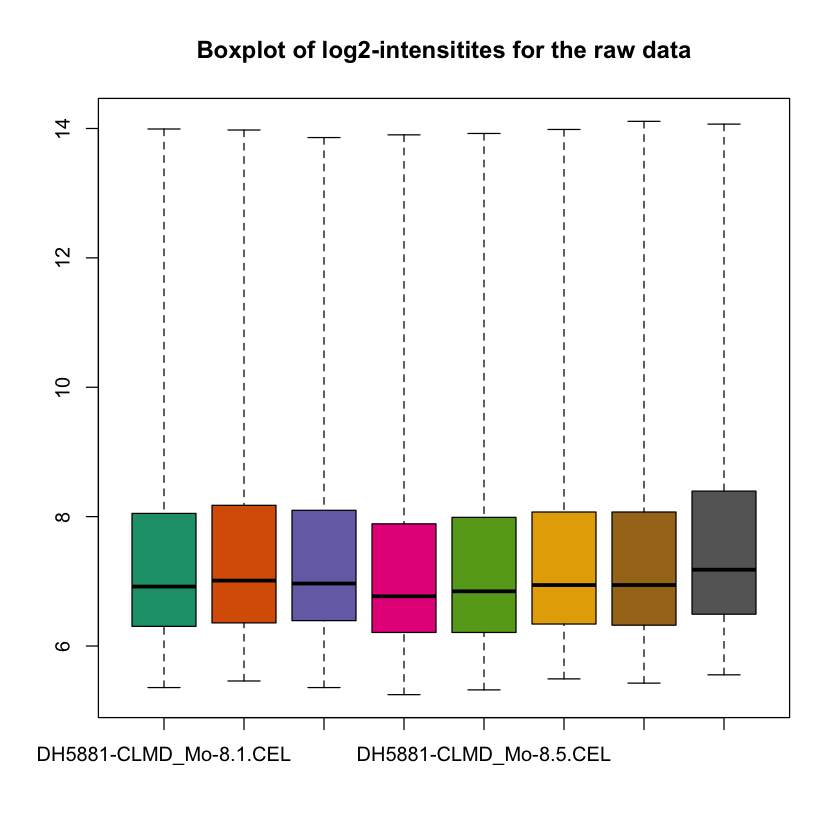

In [19]:
oligo::boxplot(raw_data, target = "core", 
               main = "Boxplot of log2-intensitites for the raw data")

In [21]:
head(ls("package:mta10probeset.db"))

[1] "mta10probeset"          "mta10probeset_dbconn"   "mta10probeset_dbfile"  
[4] "mta10probeset_dbInfo"   "mta10probeset_dbschema" "mta10probeset.db"

In [22]:
palmieri_eset <- oligo::rma(raw_data, target = "probeset", normalize = FALSE)

Background correcting
Calculating Expression


In [23]:
row_medians_assayData <- Biobase::rowMedians(as.matrix(Biobase::exprs(palmieri_eset)))

In [24]:
RLE_data <- sweep(Biobase::exprs(palmieri_eset), 1, row_medians_assayData)

In [25]:
RLE_data <- as.data.frame(RLE_data)

In [29]:
RLE_data_gathered <- tidyr::gather(RLE_data, samples, log2_expression_deviation)

Warning message:
“Removed 1706 rows containing non-finite values (stat_boxplot).”

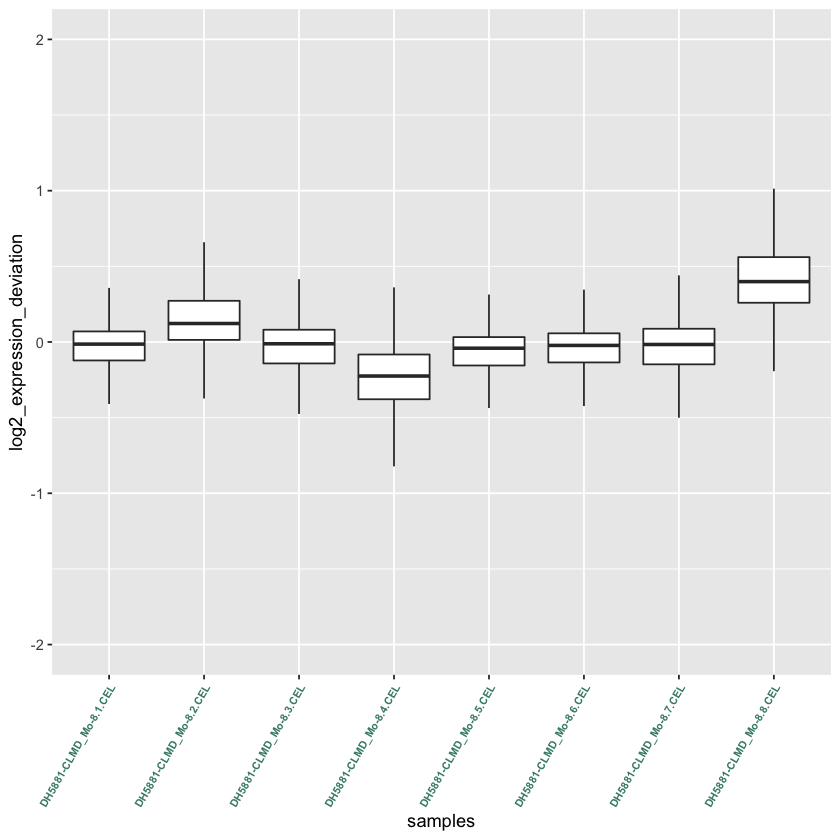

In [31]:
ggplot2::ggplot(RLE_data_gathered, aes(samples,
                                       log2_expression_deviation)) + 
  geom_boxplot(outlier.shape = NA) + 
  ylim(c(-2, 2)) + 
  theme(axis.text.x = element_text(colour = "aquamarine4", 
                                  angle = 60, size = 6.5, hjust = 1 ,
                                  face = "bold"))

In [32]:
palmieri_eset_norm_exon <- oligo::rma(raw_data, target = "probeset")

Background correcting
Normalizing
Calculating Expression


In [108]:
exp_palmieri_exon <- Biobase::exprs(palmieri_eset_norm_exon)
PCA_exon <- prcomp(t(exp_palmieri_exon), scale = FALSE)

In [115]:
PCA_exon$x

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
DH5881-CLMD_Mo-8.1.CEL,-87.93702,57.18142,-44.870593,111.89531,-19.15954,-101.995002,36.086108,2.754098e-12
DH5881-CLMD_Mo-8.2.CEL,-30.30214,-126.23799,-61.413835,83.26534,54.36754,68.739152,-40.433596,1.074440e-12
DH5881-CLMD_Mo-8.3.CEL,-134.34347,7.36091,-98.668324,-114.43501,-64.64202,7.044587,-32.310929,2.065658e-12
DH5881-CLMD_Mo-8.4.CEL,-174.47719,-12.48496,154.705156,-22.90856,29.80577,10.832524,12.291510,3.589488e-12
DH5881-CLMD_Mo-8.5.CEL,100.90004,49.18302,45.428916,50.75131,-118.25964,82.011022,1.270825,1.180416e-12
DH5881-CLMD_Mo-8.6.CEL,89.77378,125.11023,1.373088,-16.29900,87.99423,-2.367912,-86.044994,3.783857e-13
DH5881-CLMD_Mo-8.7.CEL,154.04483,-110.69399,40.995923,-42.78408,-27.19298,-95.120767,-22.851554,-6.426498e-13
DH5881-CLMD_Mo-8.8.CEL,82.34117,10.58137,-37.550330,-49.48531,57.08663,30.856396,131.992629,-1.016384e-11


In [120]:
tsne <- Rtsne(PCA_exon$x, dims = 3, perplexity=2, verbose=TRUE, max_iter = 500)

Performing PCA
Read the 8 x 8 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 3, perplexity = 2.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.00 seconds (sparsity = 0.843750)!
Learning embedding...
Iteration 50: error is 64.133334 (50 iterations in 0.00 seconds)
Iteration 100: error is 49.368003 (50 iterations in 0.00 seconds)
Iteration 150: error is 49.338561 (50 iterations in 0.00 seconds)
Iteration 200: error is 53.883698 (50 iterations in 0.00 seconds)
Iteration 250: error is 62.248064 (50 iterations in 0.00 seconds)
Iteration 300: error is 1.179204 (50 iterations in 0.00 seconds)
Iteration 350: error is 0.336654 (50 iterations in 0.00 seconds)
Iteration 400: error is 0.117730 (50 iterations in 0.00 seconds)
Iteration 450: error is 0.147070 (50 iterations in 0.00 seconds)
Iteration 500: error is 0.125037 (50 iterations in 0.00 seconds)
Fitting performed in 0.01 seconds.


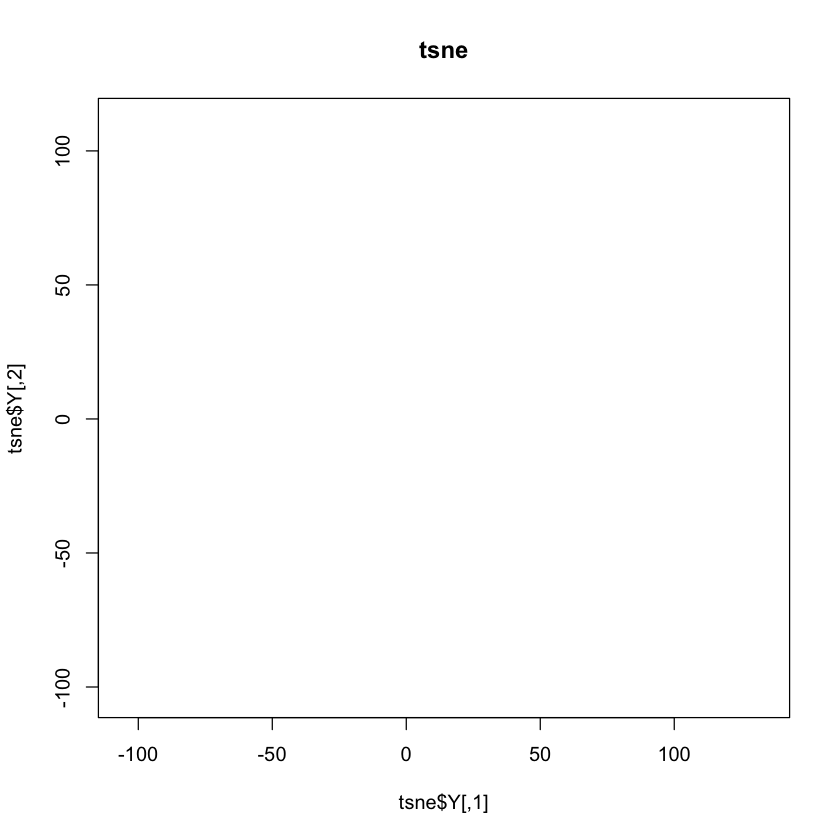

In [126]:
plot(tsne$Y, t='n', main="tsne")

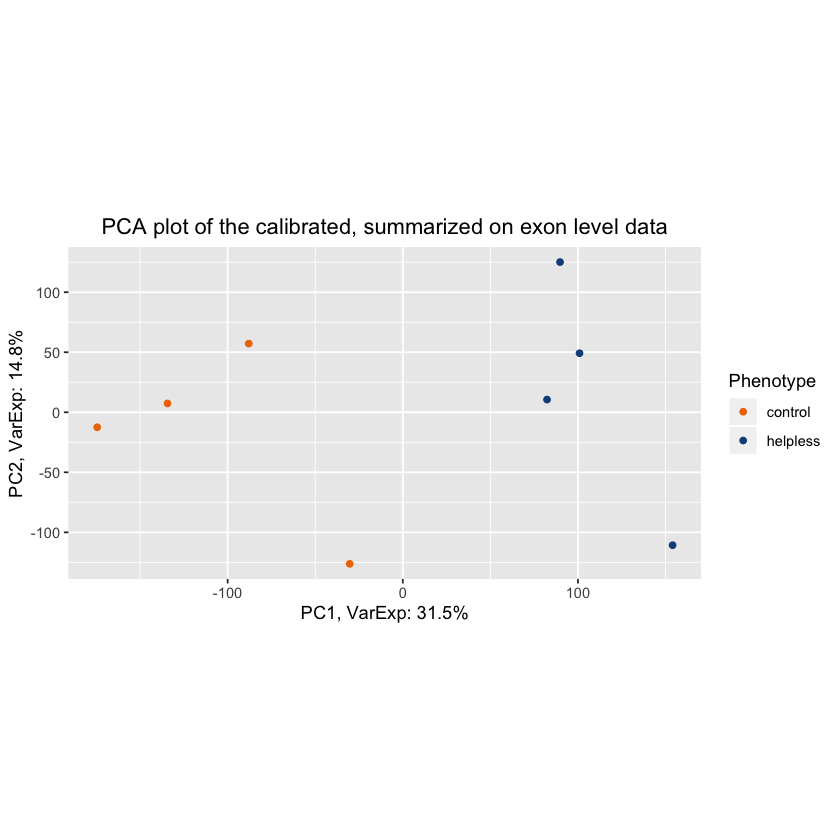

In [127]:
percentVar_exon <- round(100*PCA_exon$sdev^2/sum(PCA_exon$sdev^2),1)
sd_ratio <- sqrt(percentVar_exon[2] / percentVar_exon[1])

dataGG_exon <- data.frame(PC1 = PCA_exon$x[,1], PC2 = PCA_exon$x[,2],
                    Phenotype = 
                     Biobase::pData(palmieri_eset_norm_exon)$Phenotype)


ggplot(dataGG_exon, aes(PC1, PC2)) +
      geom_point(aes(colour = Phenotype)) +
  ggtitle("PCA plot of the calibrated, summarized on exon level data") +
  xlab(paste0("PC1, VarExp: ", percentVar_exon[1], "%")) +
  ylab(paste0("PC2, VarExp: ", percentVar_exon[2], "%")) +
  theme(plot.title = element_text(hjust = 0.5)) +
  coord_fixed(ratio = sd_ratio) +
  scale_shape_manual(values = c(4,15)) + 
  scale_color_manual(values = c("darkorange2", "dodgerblue4"))

In [36]:
annotation_for_heatmap <- data.frame(Phenotype = pData(palmieri_eset_norm_exon)$Phenotype)

In [37]:
row.names(annotation_for_heatmap) <- row.names(pData(palmieri_eset_norm_exon))

In [38]:
dists <- as.matrix(dist(t(exp_palmieri_exon), method = "manhattan"))

In [39]:
rownames(dists) <- row.names(pData(palmieri_eset_norm_exon))
hmcol <- rev(colorRampPalette(RColorBrewer::brewer.pal(9, "YlOrRd"))(255))
colnames(dists) <- NULL
diag(dists) <- NA

In [40]:
ann_colors <- list(Phenotype = c(control = "chartreuse4", helpless = "burlywood3"))

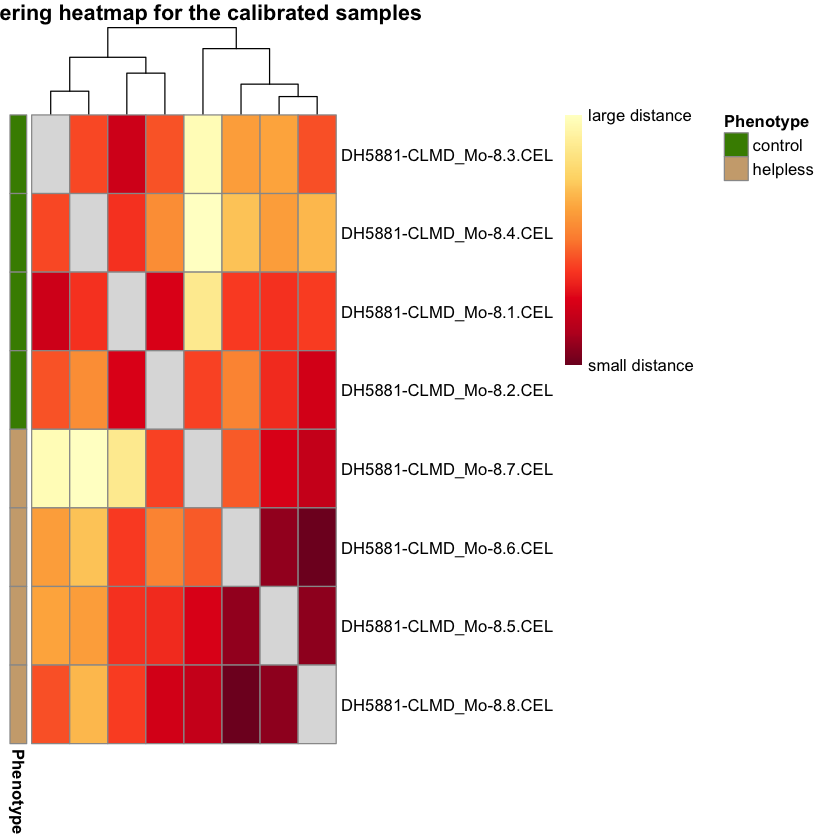

In [41]:
pheatmap(dists, col = (hmcol), 
         annotation_row = annotation_for_heatmap,
         annotation_colors = ann_colors,
         legend = TRUE, 
         treeheight_row = 0,
         legend_breaks = c(min(dists, na.rm = TRUE), 
                         max(dists, na.rm = TRUE)), 
         legend_labels = (c("small distance", "large distance")),
         main = "Clustering heatmap for the calibrated samples")

In [42]:
palmieri_medians <- rowMedians(Biobase::exprs(palmieri_eset_norm_exon))

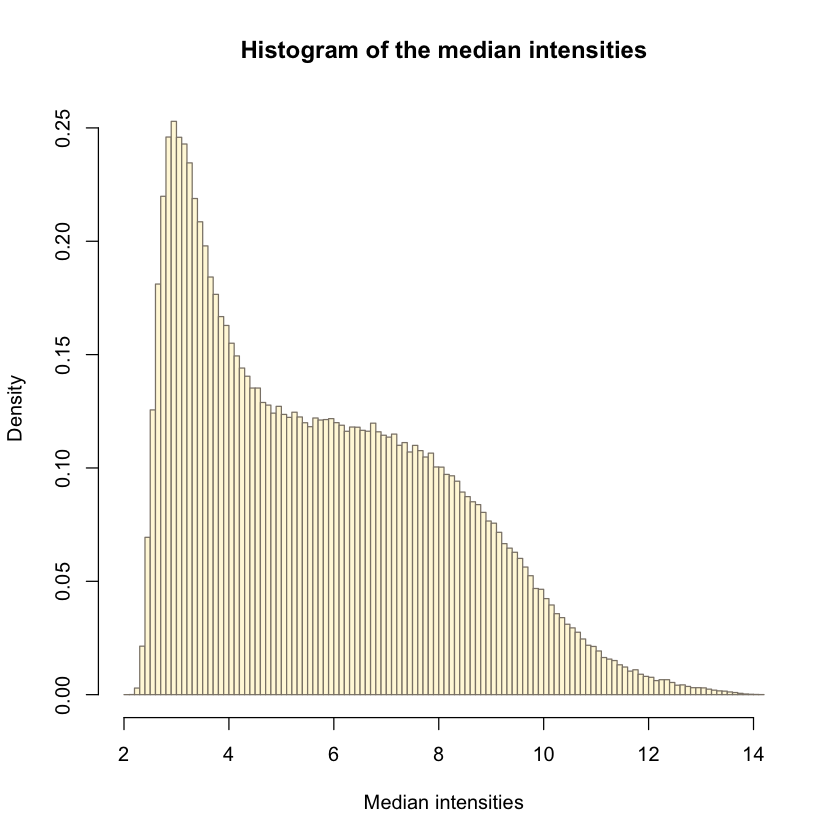

In [43]:
hist_res <- hist(palmieri_medians, 100, col = "cornsilk1", freq = FALSE, 
            main = "Histogram of the median intensities", 
            border = "antiquewhite4",
            xlab = "Median intensities")

## Intensity-based filtering based on `limma` recommendations - removing low intsnsity low variance probes

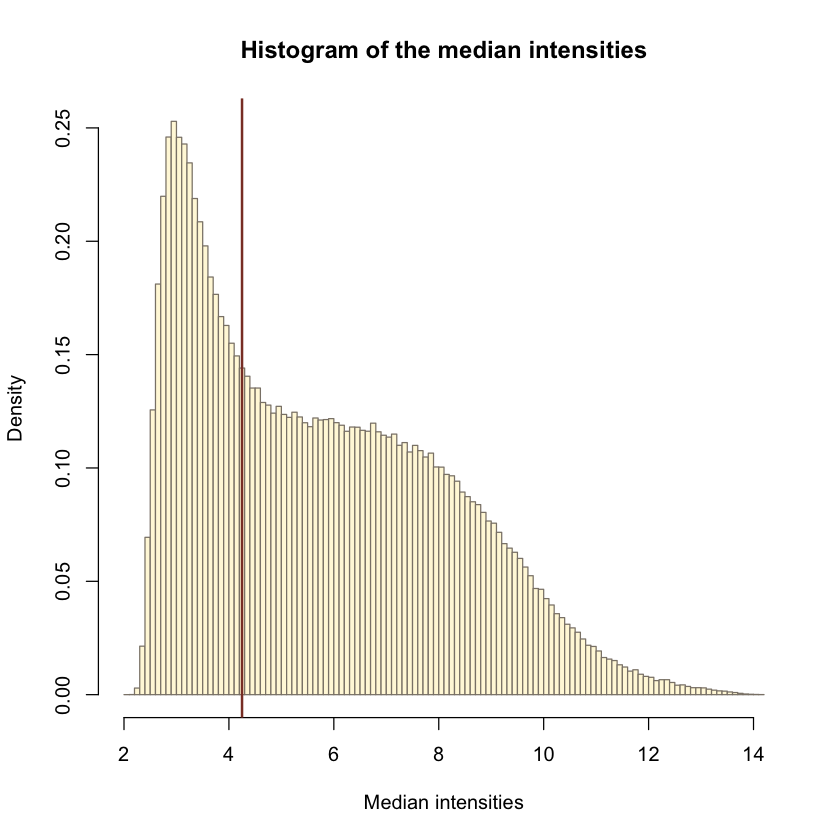

In [44]:
man_threshold <- 4.25

hist_res <- hist(palmieri_medians, 100, col = "cornsilk", freq = FALSE, 
            main = "Histogram of the median intensities",
            border = "antiquewhite4",
            xlab = "Median intensities")

abline(v = man_threshold, col = "coral4", lwd = 2)

In [46]:
no_of_samples <- table(paste0(pData(palmieri_eset_norm_exon)$Phenotype))
no_of_samples 


 control helpless 
       4        4 

In [47]:
samples_cutoff <- min(no_of_samples)

idx_man_threshold <- apply(Biobase::exprs(palmieri_eset_norm_exon), 1,
                           function(x){
                          sum(x > man_threshold) >= samples_cutoff})
                          table(idx_man_threshold)

idx_man_threshold
 FALSE   TRUE 
255415 479501 

In [48]:
palmieri_manfiltered <- subset(palmieri_eset_norm_exon, idx_man_threshold)

### Probe-based annotation for MTA 1.0

In [49]:
anno_palmieri <- AnnotationDbi::select(mta10probeset.db,
                                  keys = (featureNames(palmieri_manfiltered)),
                                  columns = c("SYMBOL", "GENENAME"),
                                  keytype = "PROBEID")

'select()' returned 1:many mapping between keys and columns


In [50]:
anno_palmieri <- subset(anno_palmieri, !is.na(SYMBOL))

In [51]:
head(anno_palmieri)

,PROBEID,SYMBOL,GENENAME
,<chr>,<chr>,<chr>
662,JUC0100000004.mm.1,Lypla1,lysophospholipase 1
663,JUC0100000005.mm.1,Lypla1,lysophospholipase 1
664,JUC0100000006.mm.1,Lypla1,lysophospholipase 1
665,JUC0100000007.mm.1,Lypla1,lysophospholipase 1
666,JUC0100000008.mm.1,Lypla1,lysophospholipase 1
667,JUC0100000009.mm.1,Lypla1,lysophospholipase 1


In [54]:
anno_grouped <- group_by(anno_palmieri, PROBEID)
anno_summarized <- 
  dplyr::summarize(anno_grouped, no_of_matches = n_distinct(SYMBOL))

head(anno_summarized)

PROBEID,no_of_matches
<chr>,<int>
JUC0100000004.mm.1,1
JUC0100000005.mm.1,1
JUC0100000006.mm.1,1
JUC0100000007.mm.1,1
JUC0100000008.mm.1,1
JUC0100000009.mm.1,1


In [55]:
anno_filtered <- filter(anno_summarized, no_of_matches > 1)

head(anno_filtered)

PROBEID,no_of_matches
<chr>,<int>
JUC0100004059.mm.1,8
JUC0100004060.mm.1,8
JUC0100004062.mm.1,8
JUC0100005710.mm.1,2
JUC0100005712.mm.1,2
JUC0100005717.mm.1,2


In [56]:
probe_stats <- anno_filtered 

nrow(probe_stats)

[1] 3214

In [57]:
dim(probe_stats)

[1] 3214    2

In [58]:
ids_to_exlude <- (featureNames(palmieri_manfiltered) %in% probe_stats$PROBEID)

In [59]:
table(ids_to_exlude)

ids_to_exlude
 FALSE   TRUE 
476287   3214 

In [60]:
palmieri_final <- subset(palmieri_manfiltered, !ids_to_exlude)

In [61]:
validObject(palmieri_final)
dim(palmieri_final)

[1] TRUE

Features  Samples 
  476287        8

In [ ]:
# colors<-rainbow(length(unique(pData(palmieri_eset_norm_exon)$Phenotype)))
# colors<-c(rep(colors[1],4), rep(colors[2],4))
# names(colors)<-row.names(samples)
# tsne <- Rtsne(samples[,-1], dims = 2, perplexity=30, verbose=TRUE, max_iter = 500)

In [70]:
head(anno_palmieri)

,PROBEID,SYMBOL,GENENAME
,<chr>,<chr>,<chr>
662,JUC0100000004.mm.1,Lypla1,lysophospholipase 1
663,JUC0100000005.mm.1,Lypla1,lysophospholipase 1
664,JUC0100000006.mm.1,Lypla1,lysophospholipase 1
665,JUC0100000007.mm.1,Lypla1,lysophospholipase 1
666,JUC0100000008.mm.1,Lypla1,lysophospholipase 1
667,JUC0100000009.mm.1,Lypla1,lysophospholipase 1


In [71]:
fData(palmieri_final)$PROBEID <- rownames(fData(palmieri_final))

In [72]:
fData(palmieri_final) <- left_join(fData(palmieri_final), anno_palmieri)

Joining, by = c("PROBEID", "SYMBOL", "GENENAME")


In [73]:
rownames(fData(palmieri_final)) <- fData(palmieri_final)$PROBEID 

In [74]:
individual <- as.character(Biobase::pData(palmieri_final)$Individual)
phenotype = pData(palmieri_eset_norm_exon)$Phenotype
design_palmieri <- model.matrix(~ 0 + phenotype)
colnames(design_palmieri)[1:2] <- c("control", "helpless")
rownames(design_palmieri) <- individual

In [77]:
contrast_matrix <- makeContrasts(control-helpless, levels = design_palmieri)

In [78]:
palmieri_fit <- eBayes(contrasts.fit(lmFit(palmieri_final, design = design_palmieri), contrast_matrix))

In [80]:
table <- topTable(palmieri_fit, number = Inf)
head(table)
nrow(subset(table, P.Value < 0.001))

,PROBEID,SYMBOL,GENENAME,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JUC0200000877.mm.1,JUC0200000877.mm.1,Il1rn,interleukin 1 receptor antagonist,2.785488,5.258402,26.76548,4.823018e-10,0.0002297141,11.320564
JUC1700009774.mm.1,JUC1700009774.mm.1,Cfb,complement factor B,3.692280,5.980488,24.33643,1.144711e-09,0.0002726055,10.896099
JUC0200010616.mm.1,JUC0200010616.mm.1,Cd40,CD40 antigen,2.444325,4.906347,21.71068,3.219806e-09,0.0005111840,10.329735
JUC0200022781.mm.1,JUC0200022781.mm.1,Sulf2,sulfatase 2,2.829965,5.343452,19.38779,8.937749e-09,0.0006906624,9.708116
PSR1700018237.mm.1,PSR1700018237.mm.1,Cfb,complement factor B,2.098927,7.215938,18.98025,1.082035e-08,0.0006906624,9.584934
JUC0500018133.mm.1,JUC0500018133.mm.1,Flt1,FMS-like tyrosine kinase 1,2.587111,4.921796,18.57306,1.314922e-08,0.0006906624,9.457135


[1] 8825

In [81]:
volcano_names <- ifelse(abs(palmieri_fit$coefficients)>=1, palmieri_fit$genes$SYMBOL, NA)

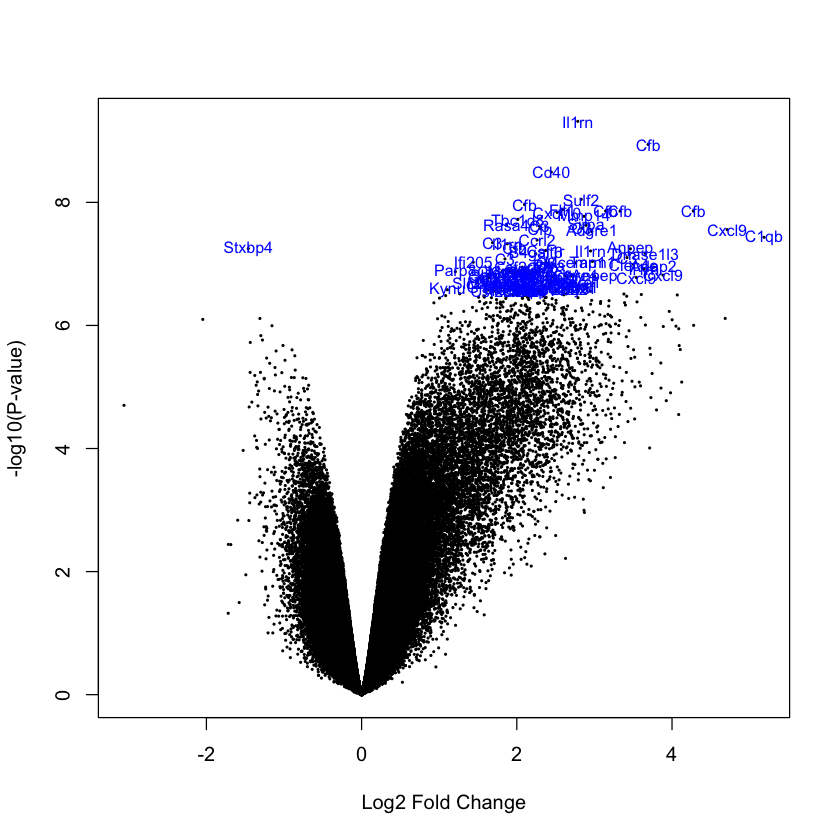

In [82]:
volcanoplot(palmieri_fit, coef = 1L, style = "p-value", highlight = 100, 
            names = volcano_names,
            xlab = "Log2 Fold Change", ylab = NULL, pch=16, cex=0.35)

In [174]:
DE_genes <- subset(table, adj.P.Val < 0.01)$PROBEID

In [224]:
DE_probes<-subset(exp_palmieri_exon, rownames(exp_palmieri_exon)%in%DE_genes)
row.names(DE_probes)<-mapIds(mta10probeset.db, 
      keys = rownames(DE_probes), 
      keytype = "PROBEID",
      column = "SYMBOL")

'select()' returned 1:1 mapping between keys and columns


In [227]:
head(DE_probes)
dim(DE_probes)

,DH5881-CLMD_Mo-8.1.CEL,DH5881-CLMD_Mo-8.2.CEL,DH5881-CLMD_Mo-8.3.CEL,DH5881-CLMD_Mo-8.4.CEL,DH5881-CLMD_Mo-8.5.CEL,DH5881-CLMD_Mo-8.6.CEL,DH5881-CLMD_Mo-8.7.CEL,DH5881-CLMD_Mo-8.8.CEL
Ly96,6.498908,6.003929,6.215526,6.449868,5.131434,5.003853,5.002140,5.552447
Tfap2d,5.556714,4.756430,5.054698,5.309663,6.344843,6.335846,6.598170,6.316815
Dst,5.810392,5.484278,5.398253,5.732689,4.734357,4.642704,4.549382,4.631992
Stat1,8.721595,8.712888,8.647198,8.714972,7.848012,7.830846,8.131137,8.070244
Sgo2a,6.154821,6.532704,6.462509,6.174416,7.213086,7.032449,7.078044,7.129298
Bmpr2,8.862426,8.892807,9.322889,9.369148,7.892115,8.228051,8.006053,8.212680


[1] 3439    8

In [235]:
length(unique(rownames(DE_probes)))

[1] 665

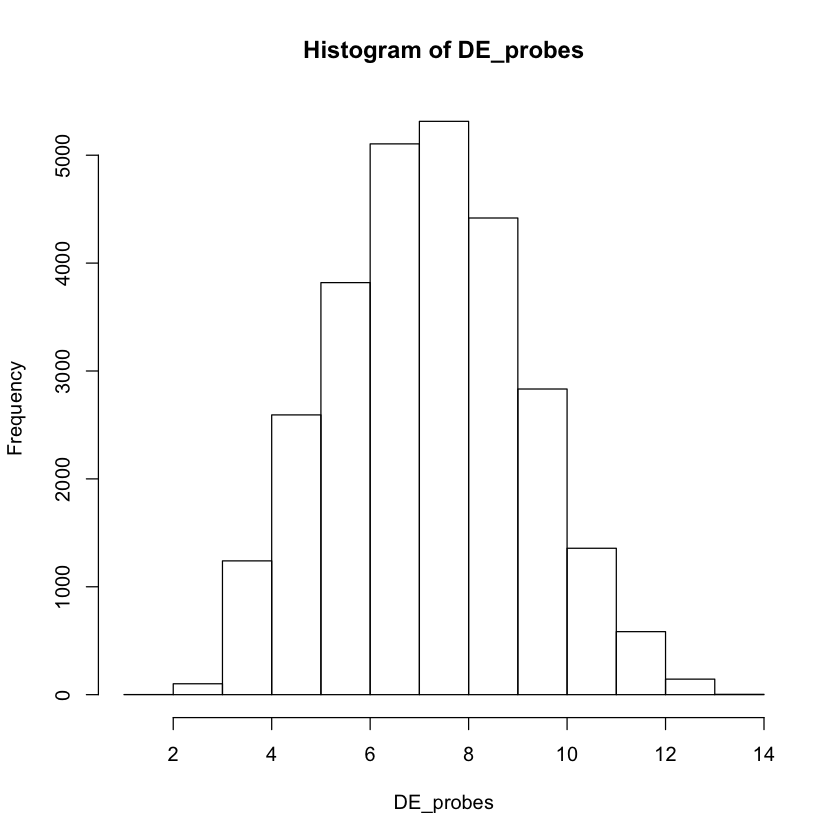

In [239]:
hist(DE_probes)

In [403]:
head(DE_probes)

Genes,DH5881-CLMD_Mo-8.1.CEL,DH5881-CLMD_Mo-8.2.CEL,DH5881-CLMD_Mo-8.3.CEL,DH5881-CLMD_Mo-8.4.CEL,DH5881-CLMD_Mo-8.5.CEL,DH5881-CLMD_Mo-8.6.CEL,DH5881-CLMD_Mo-8.7.CEL,DH5881-CLMD_Mo-8.8.CEL
Ly96,6.4989078011511,6.00392860904284,6.21552587056663,6.4498684444719,5.13143397821469,5.00385296875918,5.00214029429013,5.55244698285997
Tfap2d,5.55671376034274,4.7564298372816,5.05469824556032,5.30966275985534,6.34484297106012,6.33584558887652,6.59816998078319,6.31681506243619
Dst,5.81039226472897,5.48427754831785,5.3982527917554,5.73268861203112,4.73435718910872,4.6427040569046,4.54938188428122,4.63199239349668
Stat1,8.72159512261992,8.71288774487243,8.6471984436419,8.71497161546693,7.84801209914155,7.83084638481857,8.13113748624084,8.07024351695715
Sgo2a,6.15482127643032,6.53270407080738,6.46250910258854,6.17441582536159,7.21308584799296,7.03244901769755,7.0780439758865,7.12929801007517
Bmpr2,8.86242557036049,8.89280669922051,9.32288852183557,9.36914839375394,7.89211502078069,8.22805078574925,8.00605342258667,8.21267977252355


Drawing heatmap (from https://jcoliver.github.io/learn-r/008-ggplot-dendrograms-and-heatmaps.html)

In [331]:
suppressWarnings(DE_probes_collapsed<-aggregate(DE_probes ~ Genes, data=DE_probes, FUN=function(x) mean(as.numeric(x))))
DE_probes_collapsed<-subset(DE_probes_collapsed, select=-c(2))
row.names(DE_probes_collapsed)<-DE_probes_collapsed$Genes
DE_probes_collapsed<-subset(DE_probes_collapsed, select=-c(1))
head(DE_probes_collapsed)
dim(DE_probes_collapsed)

,DH5881-CLMD_Mo-8.1.CEL,DH5881-CLMD_Mo-8.2.CEL,DH5881-CLMD_Mo-8.3.CEL,DH5881-CLMD_Mo-8.4.CEL,DH5881-CLMD_Mo-8.5.CEL,DH5881-CLMD_Mo-8.6.CEL,DH5881-CLMD_Mo-8.7.CEL,DH5881-CLMD_Mo-8.8.CEL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610043K17Rik,4.376436,4.622442,4.635330,4.616076,5.328280,5.167055,5.268329,5.336867
4732471J01Rik,8.254637,8.132877,8.334444,8.247214,8.972810,9.240361,8.807118,8.889961
4930455H04Rik,5.122322,4.946904,4.776912,4.785473,5.922736,5.737426,5.624585,6.106946
4931406C07Rik,7.142932,6.997816,6.848797,7.141595,5.843610,6.285550,5.776884,6.259065
5031439G07Rik,7.105718,6.905480,7.452633,7.554447,5.887804,6.084017,5.873814,6.001016
Abca1,5.688860,5.597813,6.139285,6.841574,3.842399,3.645606,3.984059,4.081897


[1] 664   8

In [466]:
dpc<-t(DE_probes_collapsed)
dpc.scaled<-scale(dpc)
dpc.scaled<-as.data.frame(cbind(rownames(dpc.scaled), c(rep("control", 4), rep("helpless", 4)), dpc.scaled))
colnames(dpc.scaled)[1]<-"sample"
colnames(dpc.scaled)[2]<-"treatment"
rownames(dpc.scaled)<-c()
head(dpc.scaled)

sample,treatment,0610043K17Rik,4732471J01Rik,4930455H04Rik,4931406C07Rik,5031439G07Rik,Abca1,Abca3,Abcc5,⋯,Wdfy4,Wdr48,Wfdc17,Wls,Zc3h12a,Zc3h12c,Zfp36l1,Zfp385a,Zfp516,Zfp62
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
DH5881-CLMD_Mo-8.1.CEL,control,-1.38077025364274,-0.855371467603922,-0.480369965981358,1.07078158957652,0.689473093541227,0.578832952214642,0.970148212951938,0.956772796395218,⋯,0.634700199967691,-0.92181127887013,0.461012967161856,0.773692963490392,0.769093126691565,0.388876720095369,0.611404497326039,0.691915581947704,0.930928940612509,0.799714390116885
DH5881-CLMD_Mo-8.2.CEL,control,-0.754538848497153,-1.14851052508238,-0.810057412240346,0.814324146933675,0.412025568808096,0.504728950166786,0.663773627737507,0.536240608422101,⋯,0.612229209153159,-0.996231232046358,0.453470224330786,0.636324966875861,0.663568658157678,0.805887476059492,0.856274138548103,0.852808637783716,0.795193791258627,0.754838345281497
DH5881-CLMD_Mo-8.3.CEL,control,-0.721731757791595,-0.663234509058121,-1.12954943152007,0.550970199780223,1.17015681197514,0.945440178344623,0.974949234877507,1.00596848426107,⋯,1.22588444418451,-0.807649762273825,1.09996398395573,0.867616465654673,1.15167991367834,1.0515366735355,1.11366069488891,0.890850070342864,0.934647431299157,0.897324343677691
DH5881-CLMD_Mo-8.4.CEL,control,-0.770744932815398,-0.873241719858168,-1.11346007289153,1.06841803861909,1.3112298170702,1.51704260676209,1.05507538742271,1.17938972460438,⋯,1.16399979600516,-0.893854653217728,1.49221766177992,1.32264051163636,1.09376567971693,1.30874862680646,1.02257080915088,1.24578041785326,0.943075083255184,1.24297111423979
DH5881-CLMD_Mo-8.5.CEL,helpless,1.04223805173537,0.873648704473609,1.02396488113673,-1.22545245282461,-0.998059304351352,-0.9240252435099,-0.584608219411974,-0.887875860761193,⋯,-1.02149337818878,0.356043174875105,-0.995555836774338,-1.05562386148559,-0.801709984650667,-0.953260746160296,-0.584509977693666,-1.06598923888855,-0.68078082283425,-0.888321363164692
DH5881-CLMD_Mo-8.6.CEL,helpless,0.631823846485555,1.51778277840567,0.675685971377914,-0.444431957315919,-0.726187724565217,-1.08419756344103,-0.852501775542736,-0.9682456229794,⋯,-0.88036161538222,1.0004835269004,-0.713185556937247,-1.23257258973379,-1.1316630116111,-0.754170368630071,-1.36742160923855,-0.78545863457327,-1.31710756849592,-0.93763686312682


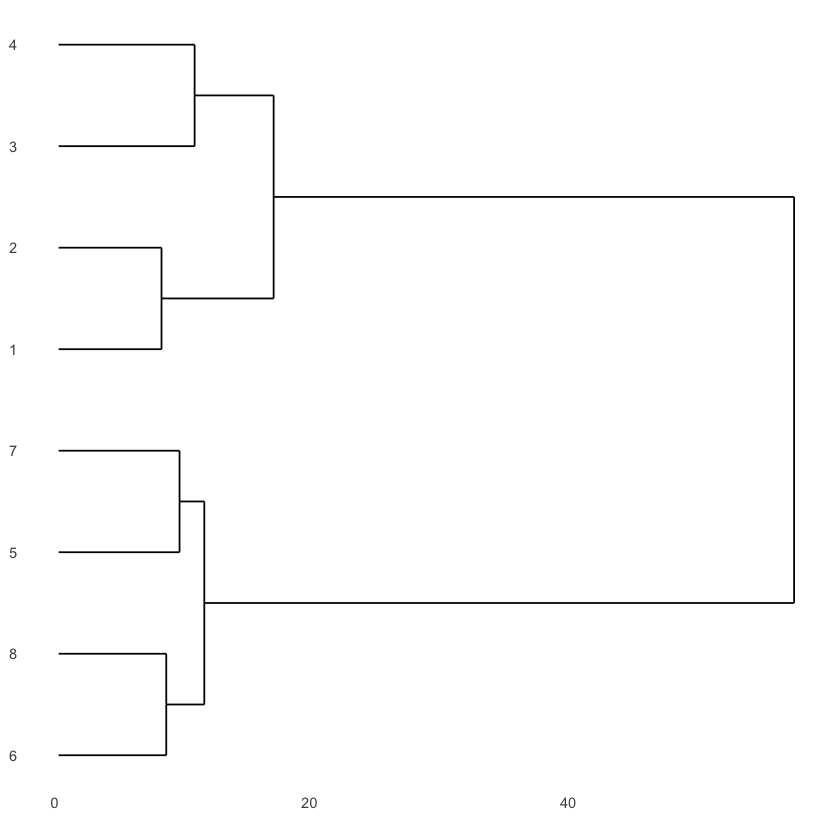

In [467]:
dpc.matrix <- as.matrix(dpc.scaled[, -c(1:2)])
rownames(dpc.matrix) <- dpc.scaled$samples
dpc.dendro <- as.dendrogram(hclust(d = dist(x = dpc.matrix)))
dendro.plot <- ggdendrogram(data = dpc.dendro, rotate = TRUE)
print(dendro.plot)

In [468]:
dpc.long <- melt(dpc.scaled, id = c("sample", "treatment"))
colnames(dpc.long)[3]<-"gene"
colnames(dpc.long)[4]<-"expression"
dpc.long<-transform(dpc.long, expression=as.numeric(expression))
head(dpc.long)

sample,treatment,gene,expression
<chr>,<chr>,<fct>,<dbl>
DH5881-CLMD_Mo-8.1.CEL,control,0610043K17Rik,-1.3807703
DH5881-CLMD_Mo-8.2.CEL,control,0610043K17Rik,-0.7545388
DH5881-CLMD_Mo-8.3.CEL,control,0610043K17Rik,-0.7217318
DH5881-CLMD_Mo-8.4.CEL,control,0610043K17Rik,-0.7707449
DH5881-CLMD_Mo-8.5.CEL,helpless,0610043K17Rik,1.0422381
DH5881-CLMD_Mo-8.6.CEL,helpless,0610043K17Rik,0.6318238


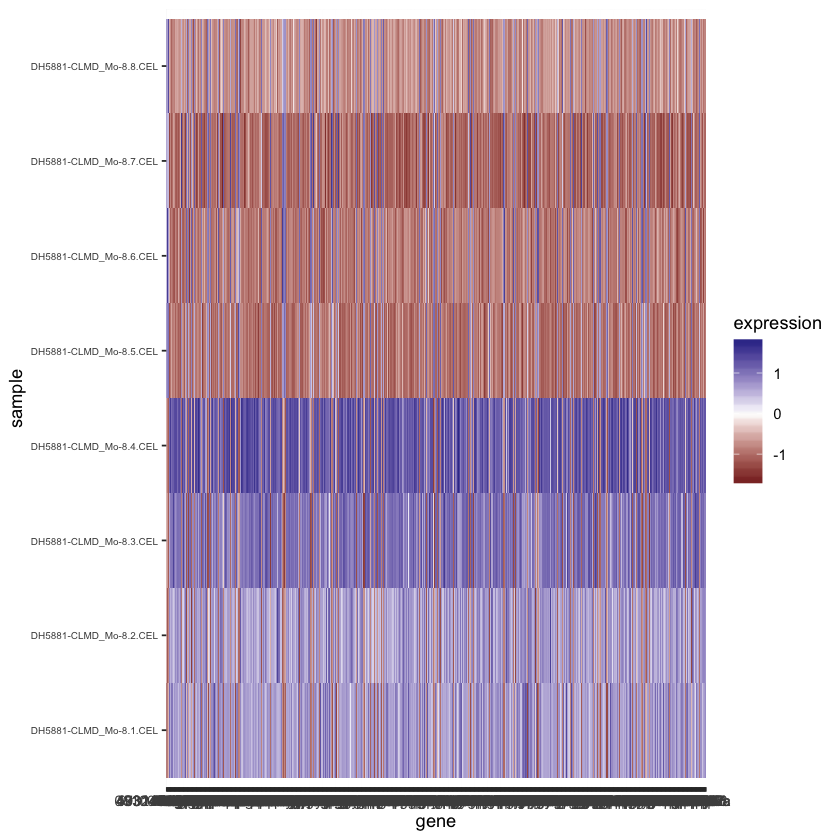

In [469]:
heatmap.plot <- ggplot(data = dpc.long, aes(x = gene, y = sample)) +
  geom_tile(aes(fill = expression)) +
  scale_fill_gradient2() +
  theme(axis.text.y = element_text(size = 6))

# Preview the heatmap
print(heatmap.plot)

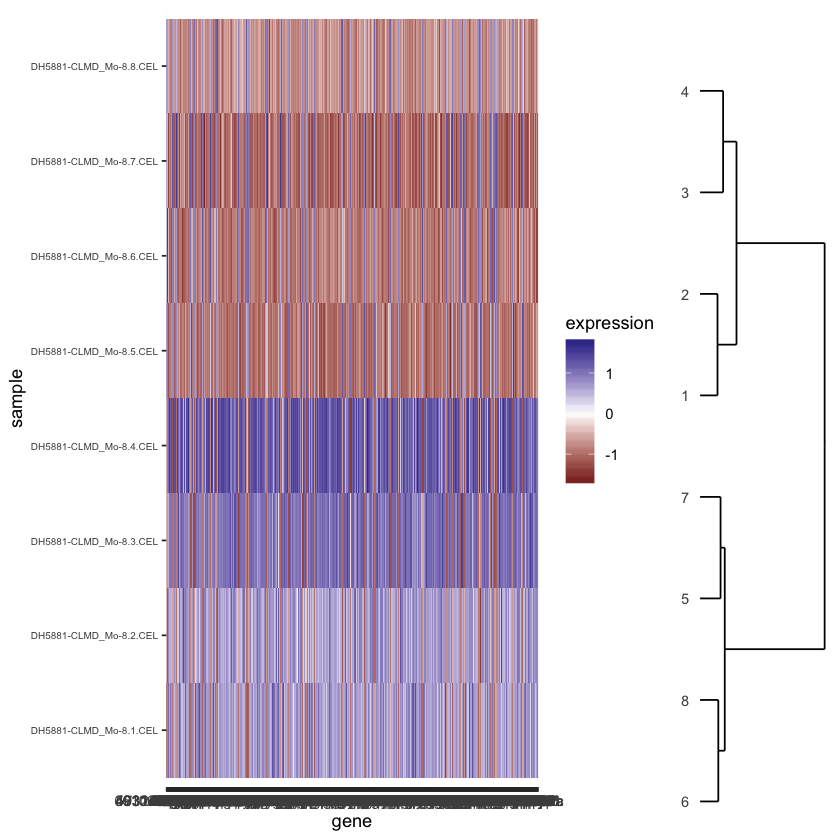

In [470]:
grid.newpage()
print(heatmap.plot, vp = viewport(x = 0.4, y = 0.5, width = 0.8, height = 1.0))
print(dendro.plot, vp = viewport(x = 0.90, y = 0.445, width = 0.2, height = 1.0))

In [473]:
dpc.order <- order.dendrogram(dpc.dendro)

Order the levels according to their position in the cluster

In [475]:
dpc.long$sample <- factor(x = dpc.long$sample,
                               levels = dpc.scaled$sample[dpc.order], 
                               ordered = TRUE)

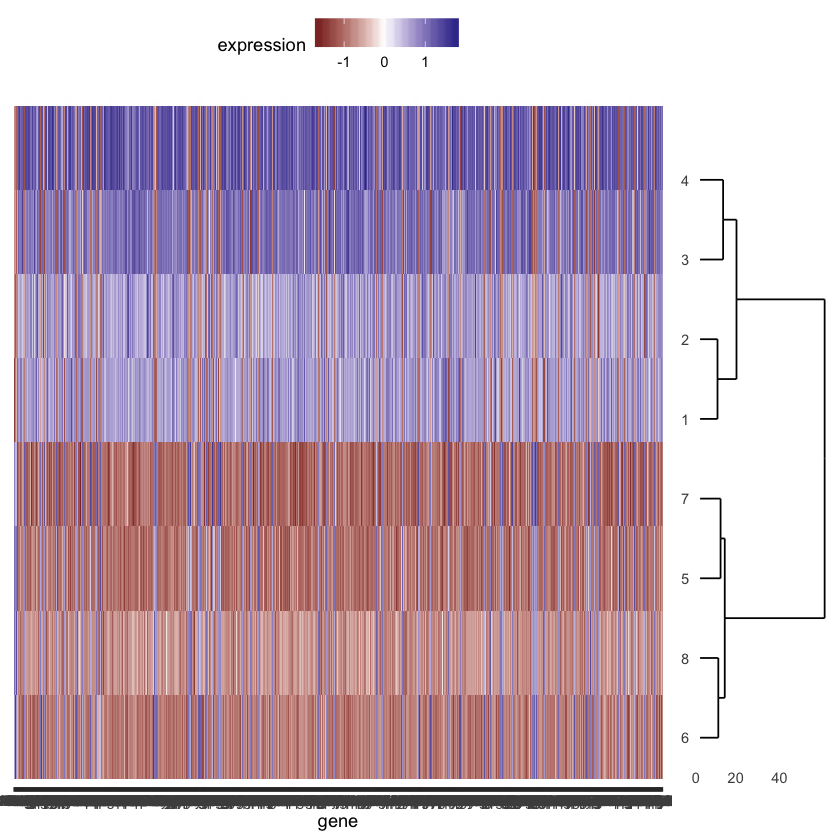

In [485]:
# Heatmap
heatmap.plot <- ggplot(data = dpc.long, aes(x = gene, y = sample)) +
  geom_tile(aes(fill = expression)) +
  scale_fill_gradient2() +
  theme(axis.text.y = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        legend.position = "top")

grid.newpage()
print(heatmap.plot, vp = viewport(x = 0.4, y = 0.5, width = 0.8, height = 1.0))
print(dendro.plot, vp = viewport(x = 0.90, y = 0.43, width = 0.2, height = 0.8))

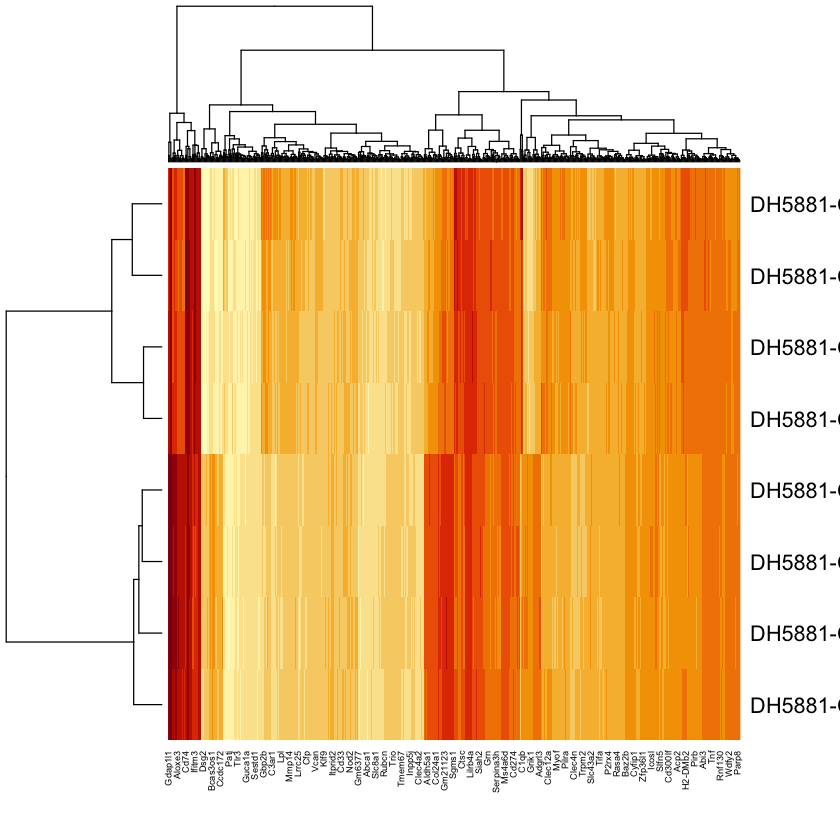

In [356]:
# pheatmap(DE_probes_collapsed, col = (hmcol), treeheight_row = 0, fontsize_row=5)
h = heatmap(as.matrix(t(DE_probes_collapsed)))

In [135]:
write.table(subset(table, P.Value < 0.05), file="control_vs_helpless.tsv",sep="\t")

In [190]:
suppressWarnings(back_genes_idx <- genefilter::genefinder(palmieri_final, as.character(DE_genes), method = "manhattan", scale = "none"))

In [191]:
back_genes_idx <- sapply(back_genes_idx, function(x)x$indices)

In [192]:
back_genes <- featureNames(palmieri_final)[back_genes_idx]
back_genes <- setdiff(back_genes, DE_genes)

In [193]:
intersect(back_genes, DE_genes)

character(0)

In [194]:
length(back_genes)

[1] 7308

>When comparing the “background gene” curve to the “foreground gene” curve, we see a similar curve shape, indicating a sensible background matching (Figure 15). Note that the right-shift of the “foreground-gene” curve in comparison to the “background-gene” curve indicates that DE-genes are generally very highly expressed, so that it wasn’t possible to find background-genes with exactly equal overall expression distribution.

>The “all gene” curve has the leftmost curve maximum; this can be explained by a high number of lowly expressed genes in all samples and shows that a background matching is sensible in order to avoid biases.

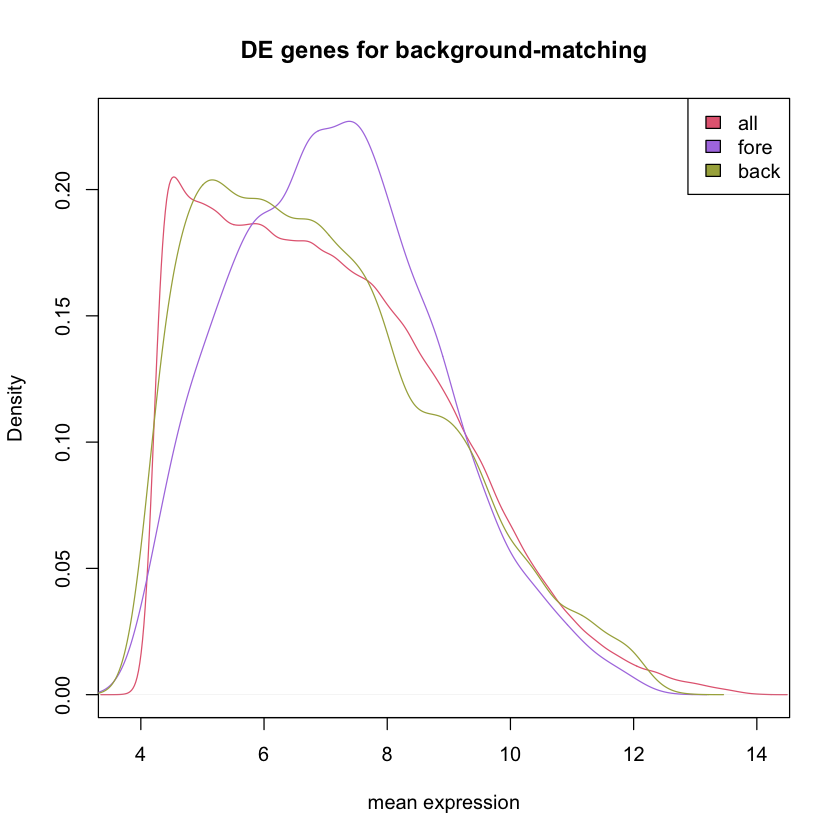

In [195]:
multidensity(list(
        all = table[,"AveExpr"] ,
        fore = table[DE_genes , "AveExpr"],
        back = table[rownames(table) %in% back_genes, "AveExpr"]),
        col = c("#e46981", "#ae7ee2", "#a7ad4a"),
     xlab = "mean expression",
   main = "DE genes for background-matching")

In [178]:
DE_symbols<-unique(mapIds(mta10probeset.db, 
      keys = DE_genes, 
      keytype = "PROBEID",
      column = "SYMBOL"))

'select()' returned 1:1 mapping between keys and columns


In [179]:
writeLines(DE_symbols, file("de.txt"))

[Enrichr link](https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=019814da5b4975fa6123318676a26224)